# Using LSTMs, CNNs, GRUs with a larger dataset

you use different kinds of layers to see how they affect the model.

You will use the glue/sst2 dataset, which is available through tensorflow_datasets.

The General Language Understanding Evaluation (GLUE) benchmark (https://gluebenchmark.com/) is a collection of resources for training, evaluating, and analyzing natural language understanding systems.

These resources include the Stanford Sentiment Treebank (SST) dataset that consists of sentences from movie reviews and human annotations of their sentiment. This colab uses version 2 of the SST dataset.

The splits are:

*   train	67,349
*   validation	872


and the column headings are:

*   sentence
*   label


For more information about the dataset, see [https://www.tensorflow.org/datasets/catalog/glue#gluesst2](https://www.tensorflow.org/datasets/catalog/glue#gluesst2)

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

# Get the dataset


In [11]:
# Get the dataset.
# It has 70000 items, so might take a while to download
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)


FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence': Text(shape=(), dtype=string),
})
2
['negative', 'positive']


In [12]:
# Get the training and validation datasets
dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<_PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [13]:
# Print some of the entries
for example in dataset_train.take(2):
  review, label = example["sentence"], example["label"]
  print("Review:", review)
  print("Label: %d \n" % label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [14]:
# Get the sentences and the labels
# for both the training and the validation sets
training_reviews = []
training_labels = []

validation_reviews = []
validation_labels = []

# The dataset has 67,000 training entries, but that's a lot to process here!

# If you want to take the entire dataset: WARNING: takes longer!!
# for item in dataset_train.take(-1):

# Take 10,000 reviews
for item in dataset_train.take(10000):
  review, label = item["sentence"], item["label"]
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

print ("\nNumber of training reviews is: ", len(training_reviews))

# print some of the reviews and labels
for i in range(0, 2):
  print (training_reviews[i])
  print (training_labels[i])

# Get the validation data
# there's only about 800 items, so take them all
for item in dataset_validation.take(-1):
  review, label = item["sentence"], item["label"]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))

# Print some of the validation reviews and labels
for i in range(0, 2):
  print (validation_reviews[i])
  print (validation_labels[i])



Number of training reviews is:  10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


# Tokenize the words and sequence the sentences


In [15]:
# There's a total of 21224 words in the reviews
# but many of them are irrelevant like with, it, of, on.
# If we take a subset of the training data, then the vocab
# will be smaller.

# A reasonable review might have about 50 words or so,
# so we can set max_length to 50 (but feel free to change it as you like)

vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index


# Pad the sequences

In [16]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length,
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

# Create the model using an Embedding

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            64000     
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [18]:
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))


Epoch 1/20
313/313 [==============================] - 16s 50ms/step - loss: 0.6835 - accuracy: 0.5554 - val_loss: 0.6889 - val_accuracy: 0.5126
Epoch 2/20
313/313 [==============================] - 4s 13ms/step - loss: 0.6714 - accuracy: 0.5746 - val_loss: 0.6705 - val_accuracy: 0.6089
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 0.6518 - accuracy: 0.6227 - val_loss: 0.6473 - val_accuracy: 0.6330
Epoch 4/20
313/313 [==============================] - 2s 7ms/step - loss: 0.6233 - accuracy: 0.6702 - val_loss: 0.6156 - val_accuracy: 0.6881
Epoch 5/20
313/313 [==============================] - 2s 8ms/step - loss: 0.5904 - accuracy: 0.7094 - val_loss: 0.5847 - val_accuracy: 0.7122
Epoch 6/20
313/313 [==============================] - 2s 7ms/step - loss: 0.5572 - accuracy: 0.7397 - val_loss: 0.5556 - val_accuracy: 0.7351
Epoch 7/20
313/313 [==============================] - 2s 6ms/step - loss: 0.5254 - accuracy: 0.7698 - val_loss: 0.5354 - val_accuracy: 0.7489
Ep

# Plot the accurracy and loss

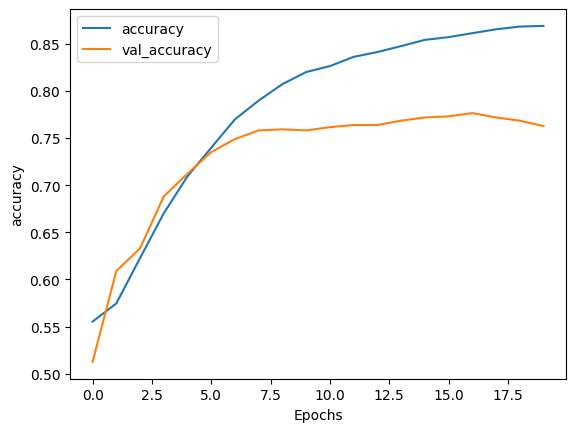

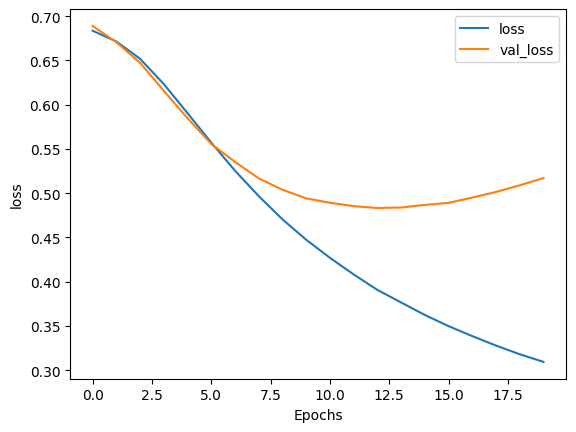

In [19]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Write a function to predict the sentiment of reviews

In [20]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]


In [21]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type,
                                 maxlen=max_length)
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)


1/1 [==============================] - 0s 80ms/step
I loved this movie
[0.3941081]


that was the worst movie I've ever seen
[0.11844173]


too much violence even for a Bond film
[0.0325942]


a captivating recounting of a cherished myth
[0.6168419]




# Define a function to train and show the results of models with different layers

In [22]:
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

# Use a CNN

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            64000     
                                                                 
 conv1d (Conv1D)             (None, 46, 16)            1296      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 23s 55ms/step - loss: 0.6883 - accuracy: 0.5590 - val_loss: 0.

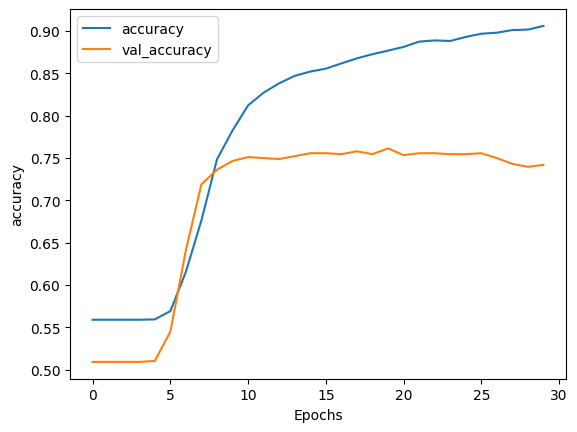

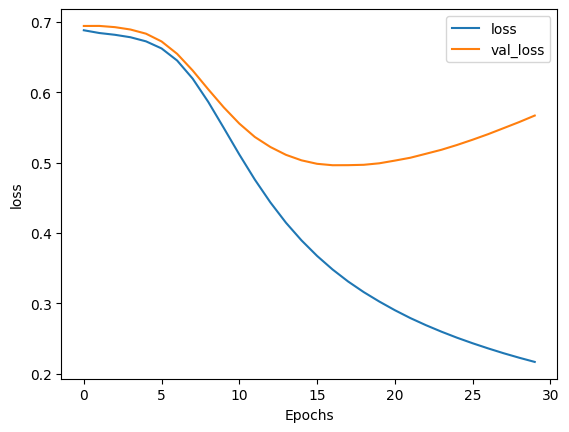

1/1 [==============================] - 0s 95ms/step
I loved this movie
[0.58947206]


that was the worst movie I've ever seen
[0.02901894]


too much violence even for a Bond film
[0.00443481]


a captivating recounting of a cherished myth
[0.6545394]




In [23]:
num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

# Use a GRU

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 24s 60ms/step - loss: 0.6892 - accuracy: 0.5590 - val_loss: 0.6927 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 5s 15ms/step - loss: 0.6864 - accuracy: 0.5590 - v

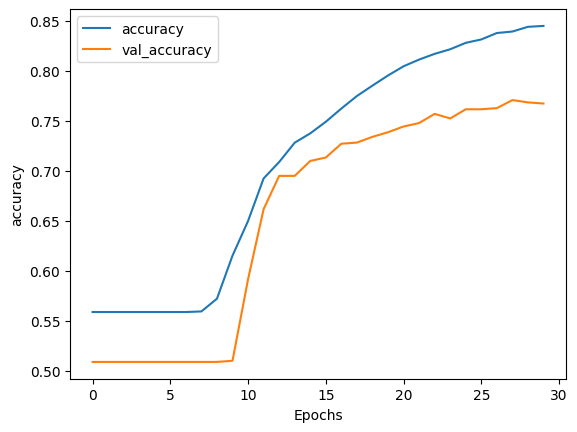

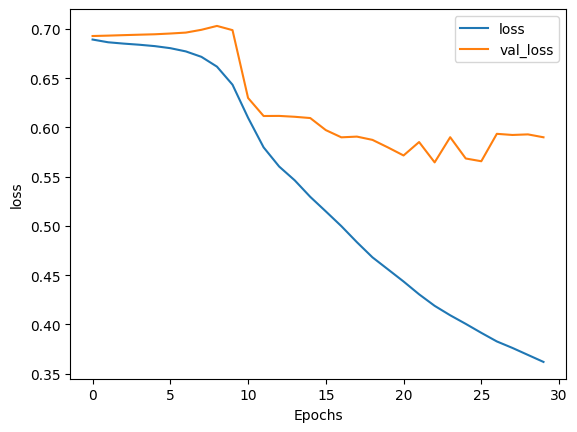

1/1 [==============================] - 1s 604ms/step
I loved this movie
[0.43827966]


that was the worst movie I've ever seen
[0.13949814]


too much violence even for a Bond film
[0.10138904]


a captivating recounting of a cherished myth
[0.43067232]




In [24]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

# Add a bidirectional LSTM

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 23s 59ms/step - loss: 0.6911 - accuracy: 0.5529 - val_loss: 0.6935 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 6s 18ms/step - loss: 0.6870 - accuracy: 0.5590 - v

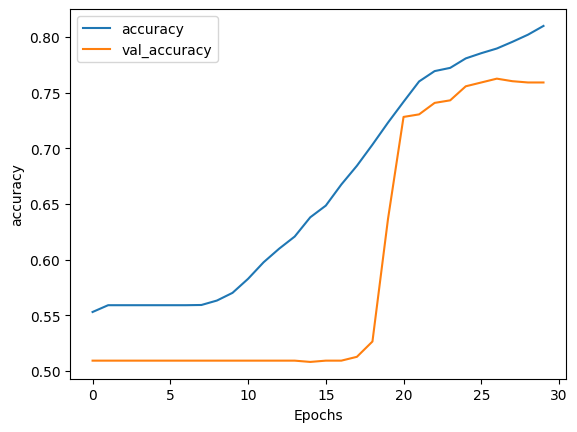

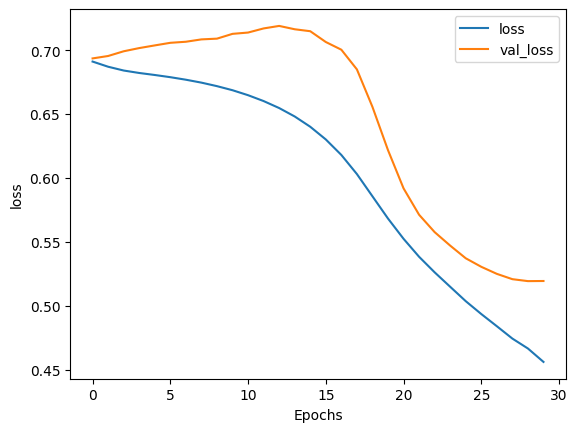

1/1 [==============================] - 1s 652ms/step
I loved this movie
[0.4962854]


that was the worst movie I've ever seen
[0.31462663]


too much violence even for a Bond film
[0.34057963]


a captivating recounting of a cherished myth
[0.5566602]




In [25]:
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

# Use multiple bidirectional LSTMs

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================

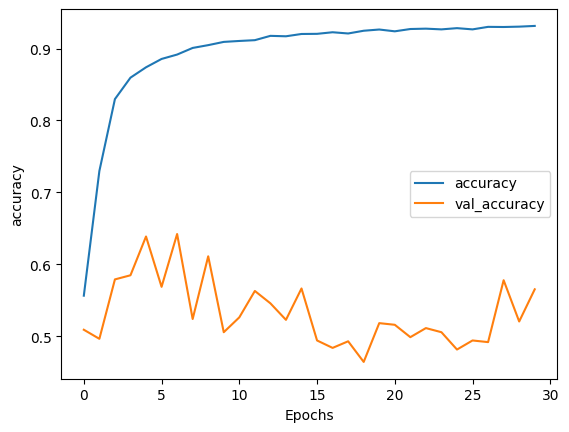

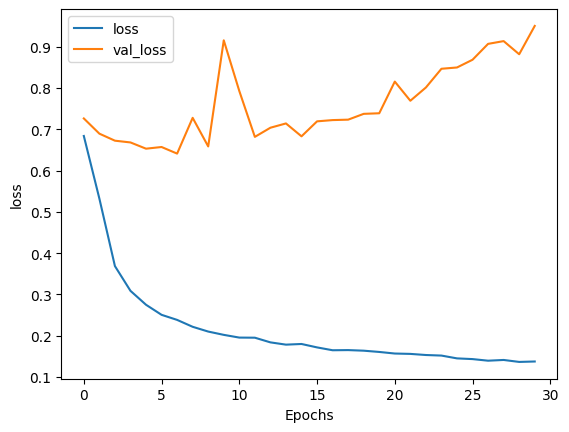

1/1 [==============================] - 1s 1s/step
I loved this movie
[0.5322359]


that was the worst movie I've ever seen
[0.07117564]


too much violence even for a Bond film
[0.0046663]


a captivating recounting of a cherished myth
[0.9972154]




In [26]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

# Try some more reviews

In [27]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time.
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director
 who made my most favorite movie ever, I was very disappointed in the tedious
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7,
               review8, review9, review10]


In [28]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
1/1 [==============================] - 0s 21ms/step
I loved this movie
[0.3941081]


that was the worst movie I've ever seen
[0.11844173]


too much violence even for a Bond film
[0.0325942]


a captivating recounting of a cherished myth
[0.6168419]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.29064378]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.48133057]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.26605204]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.50748384]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointe

In [29]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
1/1 [==============================] - 0s 49ms/step
I loved this movie
[0.58947206]


that was the worst movie I've ever seen
[0.02901894]


too much violence even for a Bond film
[0.00443481]


a captivating recounting of a cherished myth
[0.6545394]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.8886136]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.93414176]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.7177404]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.47439203]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the

In [30]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With bidirectional GRU
1/1 [==============================] - 0s 21ms/step
I loved this movie
[0.43827966]


that was the worst movie I've ever seen
[0.13949814]


too much violence even for a Bond film
[0.10138904]


a captivating recounting of a cherished myth
[0.43067232]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.09251807]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.19937623]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.07252369]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.16485667]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very di

In [31]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
1/1 [==============================] - 0s 21ms/step
I loved this movie
[0.4962854]


that was the worst movie I've ever seen
[0.31462663]


too much violence even for a Bond film
[0.34057963]


a captivating recounting of a cherished myth
[0.5566602]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.23511872]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.24116167]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.23855893]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.44300723]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I wa

In [32]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
1/1 [==============================] - 0s 23ms/step
I loved this movie
[0.5322359]


that was the worst movie I've ever seen
[0.07117564]


too much violence even for a Bond film
[0.0046663]


a captivating recounting of a cherished myth
[0.9972154]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.24544956]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.99430335]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.9976787]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.90910596]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was 